In [1]:
import numpy as np

import pandas as pd
import scipy as sp
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [8, 5], 'figure.dpi': 95})

### Generating synthetic data

* random walk process for category A's log mean, starting at 1.5 (first mean ~4.5)
* category B's mean is x 0.6 of category A
* after half points, category B is increased by 10%, this treatment is encoded as T=1


In [2]:
n_points = 2000

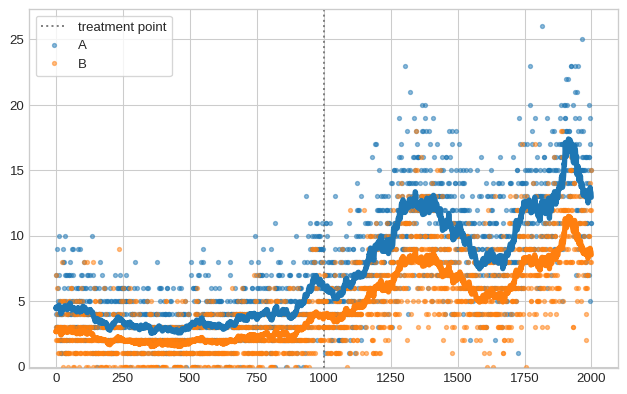

In [3]:
# cat A mean
data = pd.DataFrame(dict(
    mu_A = np.exp( 1.5 + pm.GaussianRandomWalk.dist(sigma=0.02, init=0, shape=n_points).random(size=1)[0] )
))

# cat B mean, without treatment
data = data.assign(mu_B0 = 0.6 * data.mu_A)

# cat B mean, with treatment
data = data.assign(mu_B1 = 1.1 * data.mu_B0)

# assign treatment after the 250 point
data = data.assign(T = np.r_[np.zeros(int(n_points/2)), np.ones(int(n_points/2))])

# cat B mean combined
data = data.assign(mu_B = data.mu_B0 * (1 - data['T']) + data.mu_B1 * data['T'])

# poisson sampling for both cats
data = data.assign(A = data.mu_A.map(lambda mu: pm.Poisson.dist(mu).random(size=1)[0]))
data = data.assign(B = data.mu_B.map(lambda mu: pm.Poisson.dist(mu).random(size=1)[0]))

# plot
plt.axvline(1000, linestyle=':', color='gray', label='treatment point')
ax = plt.gca()
data[['A', 'B']].plot(linewidth=0, marker='.', alpha=.5, ax=ax)
data.mu_A.plot(linewidth=4, ax=ax, color='C0', label='')
data.mu_B.plot(linewidth=4, ax=ax, color='C1', label='')
plt.gca().set(ylim=(-0.1, None))
plt.legend(frameon=True)

# keep only "observed" data
data = data[['A', 'B', 'T']]

None

In [4]:
data.sample(5)

,A,B,T
230,6,2,0.0
1070,9,9,1.0
1556,7,6,1.0
1121,8,3,1.0
151,6,0,0.0


## Model


Start with Poisson likelihood:

$$ \text{count}_i \sim \text{Pois}(\mu_i) $$

The familiar linear model for DiD, but on the log scale:

$$ \log \mu_i = \log a_i + \beta B_i + \theta B_i T_i $$

where $B = 1$ if category B, otherwise 0.

The treatment effect (as factor), is simply:

$$ t = e^{\theta} $$

We can model $a$ as random walk with an unknown step:

$$ \log a_{i+1} \sim \mathcal{N}(\log a_i, \sigma^2) $$

We are left with defining the priors for this model:

$$
\sigma \sim \text{Exponential}(1/0.5) \\
\beta \sim \mathcal{N}(0, 0.5^2) \\
\theta \sim \mathcal{N}(0, 0.5^2) 
$$


We need to transform the dataset (stack the category)

In [5]:
data2 = data.copy()
data2.index.name = 'i'
data2 = data2.set_index('T', append=True)
data2.columns.name = 'cat'
data2 = data2.stack().rename('count_').reset_index()
data2 = data2.assign(is_B = (data2.cat == 'B').astype('int'))

data2.sample(5)

,i,T,cat,count_,is_B
1457,728,0.0,B,2,1
373,186,0.0,B,4,1
290,145,0.0,A,6,0
838,419,0.0,A,1,0
3580,1790,1.0,A,13,0


In [6]:
with pm.Model() as m:
    # priors
    sigma = pm.Exponential('sigma', 1/0.5)
    log_a = pm.GaussianRandomWalk('log_a', sigma=sigma, init=pm.Normal.dist(0, 1), shape=n_points)
    log_a_i = log_a[data2.i.values]

    beta = pm.Normal('beta', 0, 0.5)
    theta = pm.Normal('theta', 0, 0.5)

    # linear model
    log_mu = log_a_i + beta * data2.is_B.values + theta * (data2.is_B * data2['T']).values

    # likelihood
    pm.Poisson('obs', mu=tt.exp(log_mu), observed=data2.count_.values)
    
    # transformed parameters
    pm.Deterministic('t', tt.exp(theta))
    pm.Deterministic('a', tt.exp(log_a))

    tr = pm.sample(3000, tune=3000, chains=2)

/tmp/ipykernel_31/302902604.py:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  tr = pm.sample(3000, tune=3000, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, beta, log_a, sigma]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 663 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
az.summary(tr, var_names=['sigma', 'beta', 't'], hdi_prob=0.95)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.021,0.002,0.016,0.025,0.000,0.0,65.0,226.0,1.01
beta,-0.526,0.026,-0.577,-0.477,0.000,0.0,3498.0,3893.0,1.00
t,1.134,0.033,1.067,1.198,0.001,0.0,3875.0,3746.0,1.00


Credible interval (95%): `[1.067, 1.198]`

True value: `1.1`

/tmp/ipykernel_31/1844329969.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(np.exp(tr['log_a']))


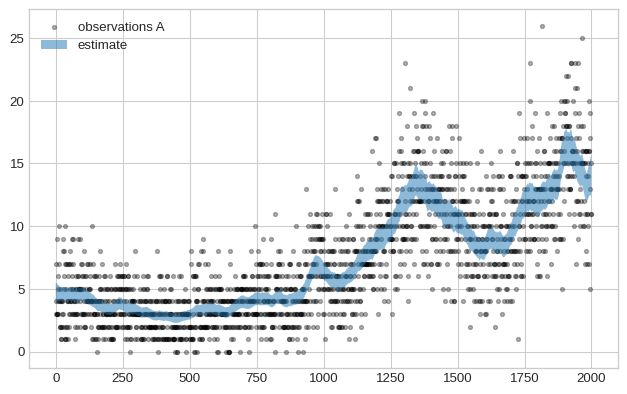

In [8]:
tmp = data2[data2.cat == 'A'][['i', 'count_']].sort_values('i').count_
plt.scatter(range(n_points), tmp, marker='.', color='k', alpha=.3, label='observations A')
tmp = az.hdi(np.exp(tr['log_a']))
plt.fill_between(range(n_points), tmp[:, 0], tmp[:, 1], alpha=.5, label='estimate')
plt.legend()
None